In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.1)


In [3]:
# File maps
price_files = {
    -2: "./round-1-island-data-bottle/prices_round_1_day_-2.csv",
    -1: "./round-1-island-data-bottle/prices_round_1_day_-1.csv",
     0: "./round-1-island-data-bottle/prices_round_1_day_0.csv"
}

trade_files = {
    -2: "./round-1-island-data-bottle/trades_round_1_day_-2.csv",
    -1: "./round-1-island-data-bottle/trades_round_1_day_-1.csv",
     0: "./round-1-island-data-bottle/trades_round_1_day_0.csv"
}

# Load and offset timestamps by 1M steps
OFFSET = 1_000_000
squid_prices_full = []
squid_trades_full = []

for i, (day, pf) in enumerate(price_files.items()):
    df = pd.read_csv(pf, sep=';')
    df = df[df['product'] == 'SQUID_INK'].copy()
    df['timestamp'] += i * OFFSET
    df['day'] = day
    squid_prices_full.append(df)

for i, (day, tf) in enumerate(trade_files.items()):
    df = pd.read_csv(tf, sep=';')
    df = df[df['symbol'] == 'SQUID_INK'].copy()
    df['timestamp'] += i * OFFSET
    df['day'] = day
    squid_trades_full.append(df)

# Combine
squid_prices = pd.concat(squid_prices_full, ignore_index=True).sort_values('timestamp')
squid_trades = pd.concat(squid_trades_full, ignore_index=True).sort_values('timestamp')

len(squid_prices), len(squid_trades)

(30000, 8837)

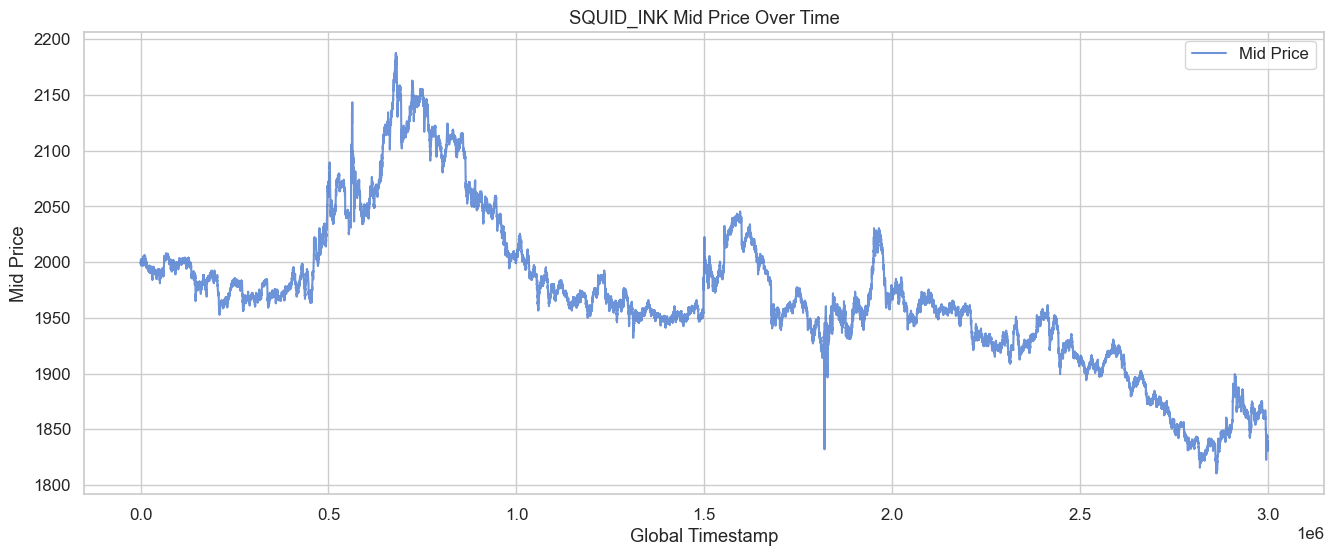

In [4]:
# Mid price over time
squid_prices['mid_price'] = squid_prices['mid_price']

plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.8)
plt.title('SQUID_INK Mid Price Over Time')
plt.xlabel('Global Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.show()


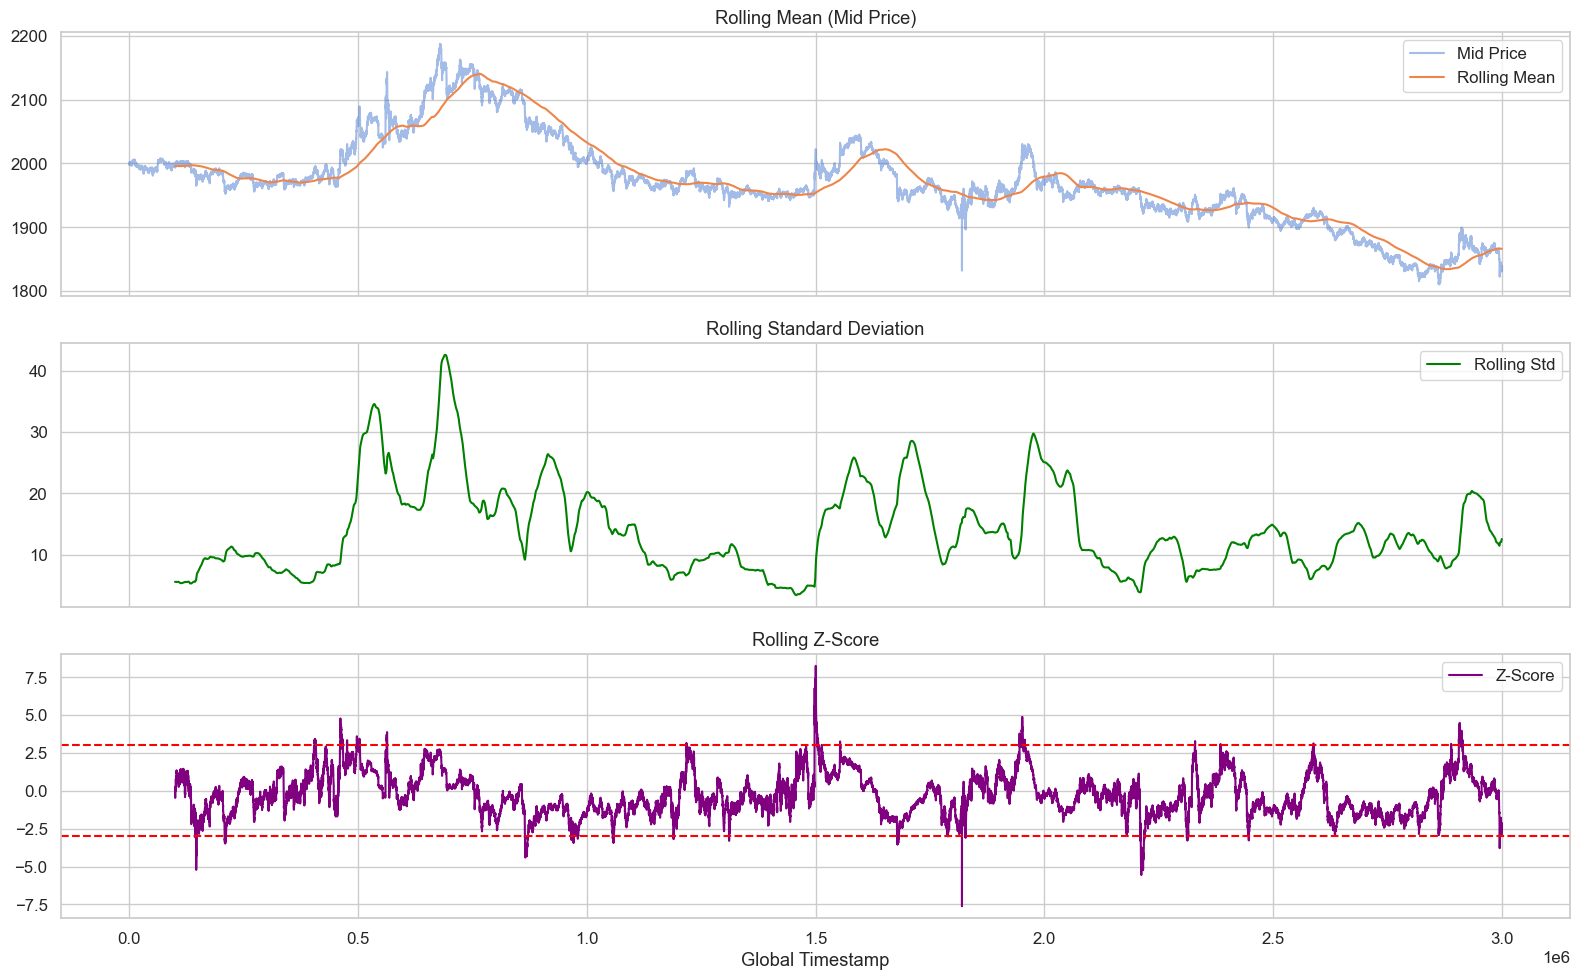

In [6]:
# Rolling stats
WINDOW = 1000
squid_prices['rolling_mean'] = squid_prices['mid_price'].rolling(WINDOW).mean()
squid_prices['rolling_std'] = squid_prices['mid_price'].rolling(WINDOW).std()
squid_prices['z_score'] = (squid_prices['mid_price'] - squid_prices['rolling_mean']) / squid_prices['rolling_std']


fig, axs = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# plot rolling mean, atop of price
axs[0].plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.5)
axs[0].plot(squid_prices['timestamp'], squid_prices['rolling_mean'], label='Rolling Mean')
axs[0].set_title('Rolling Mean (Mid Price)')
axs[0].legend()

axs[1].plot(squid_prices['timestamp'], squid_prices['rolling_std'], label='Rolling Std', color='green')
axs[1].set_title('Rolling Standard Deviation')
axs[1].legend()

axs[2].plot(squid_prices['timestamp'], squid_prices['z_score'], label='Z-Score', color='purple')
axs[2].axhline(3, color='red', linestyle='--')
axs[2].axhline(-3, color='red', linestyle='--')
axs[2].set_title('Rolling Z-Score')
axs[2].legend()

plt.xlabel('Global Timestamp')
plt.tight_layout()
plt.show()


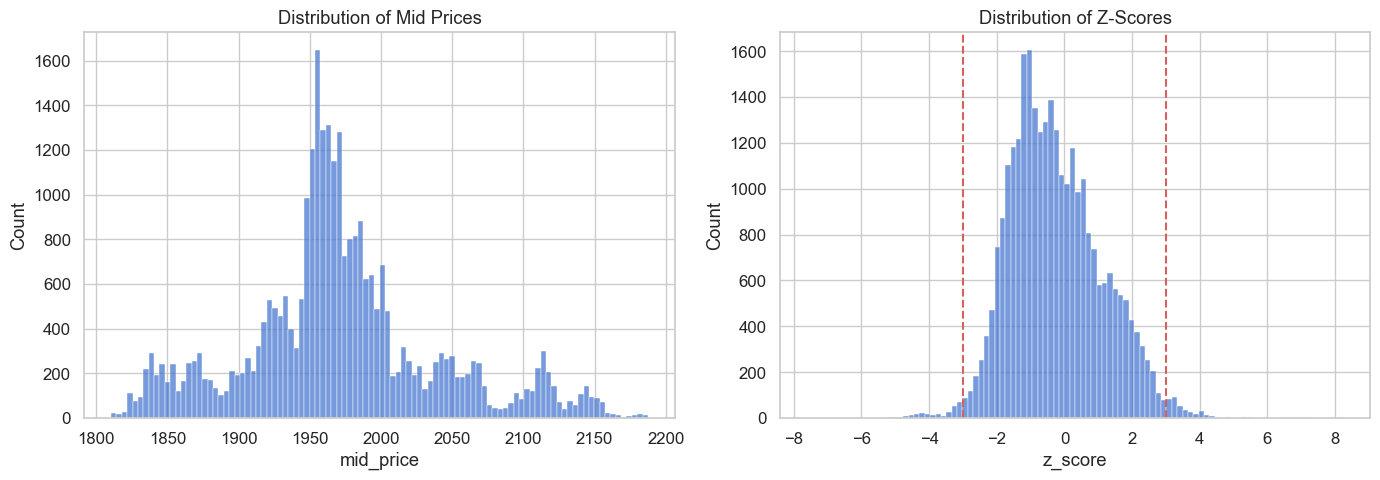

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(squid_prices['mid_price'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Mid Prices")

sns.histplot(squid_prices['z_score'].dropna(), bins=100, ax=axs[1])
axs[1].axvline(3, color='r', linestyle='--')
axs[1].axvline(-3, color='r', linestyle='--')
axs[1].set_title("Distribution of Z-Scores")

plt.tight_layout()
plt.show()


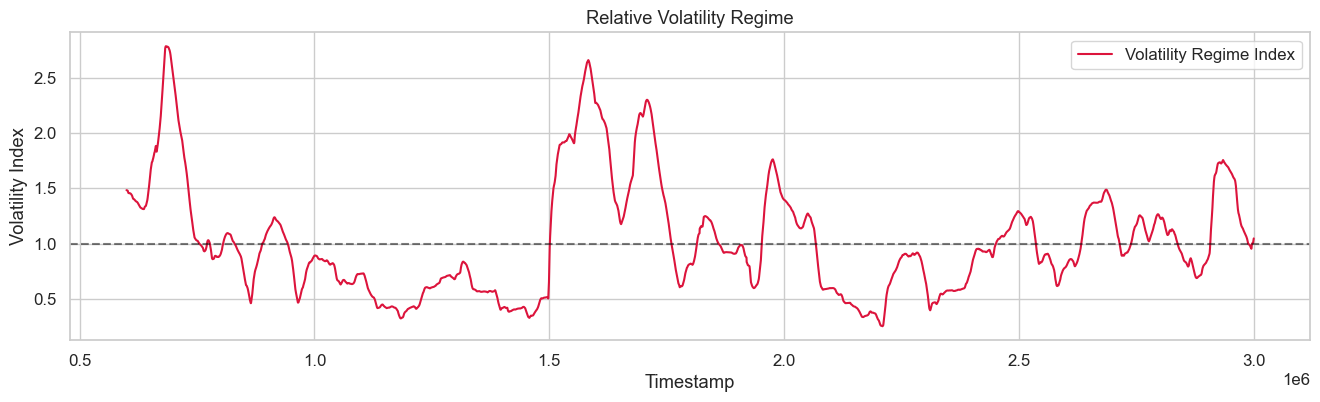

In [11]:
# Volatility regime = rolling_std / its own rolling mean
VOL_WINDOW = 5000
squid_prices['volatility_regime'] = squid_prices['rolling_std'] / squid_prices['rolling_std'].rolling(VOL_WINDOW).mean()

plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['volatility_regime'], label='Volatility Regime Index', color='crimson')
plt.axhline(1, linestyle='--', color='black', alpha=0.5)
plt.title('Relative Volatility Regime')
plt.xlabel('Timestamp')
plt.ylabel('Volatility Index')
plt.legend()
plt.show()


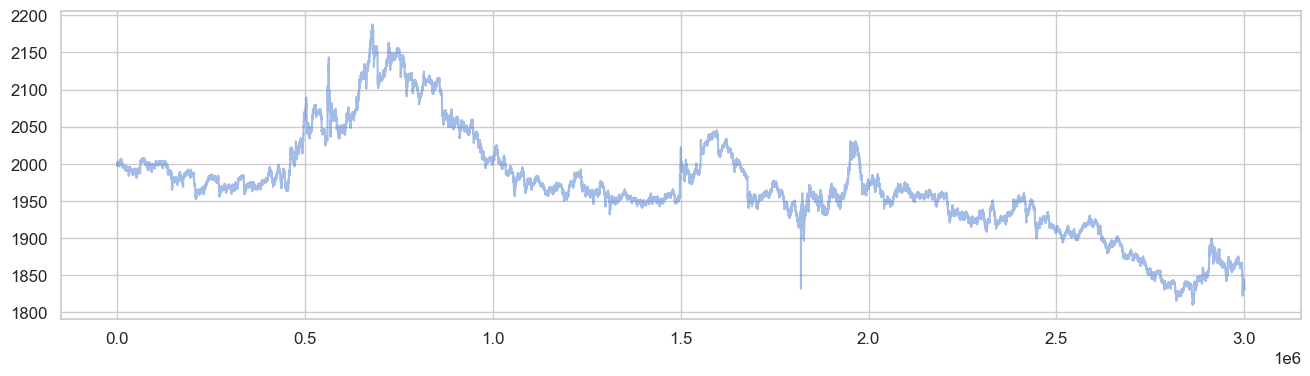

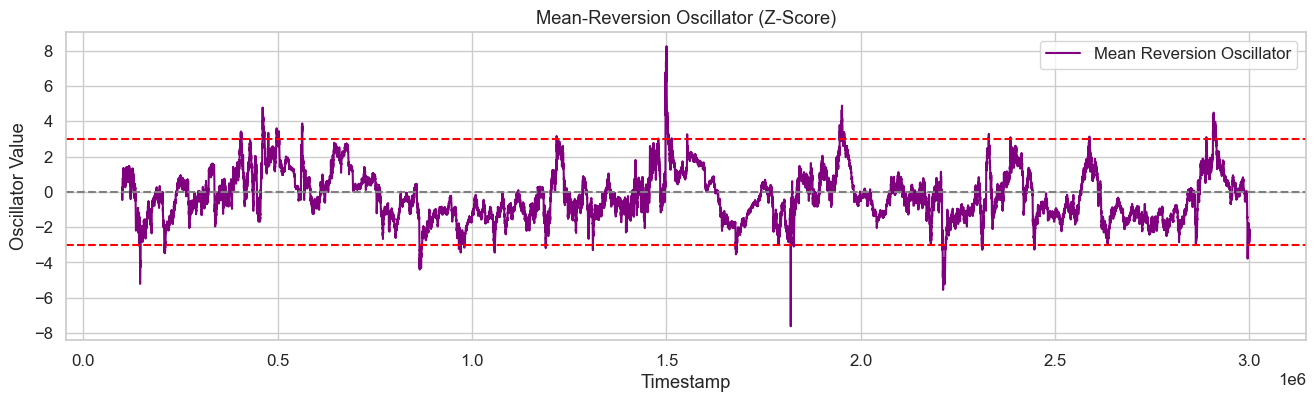

In [12]:
# Mean-reversion signal = normalized deviation from mean
squid_prices['oscillator'] = (squid_prices['mid_price'] - squid_prices['rolling_mean']) / squid_prices['rolling_std']


# plot oscillator and mid price on different graphs
plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.5)

plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['oscillator'], label='Mean Reversion Oscillator', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(3, color='red', linestyle='--')
plt.axhline(-3, color='red', linestyle='--')
plt.title('Mean-Reversion Oscillator (Z-Score)')
plt.xlabel('Timestamp')
plt.ylabel('Oscillator Value')
plt.legend()
plt.show()


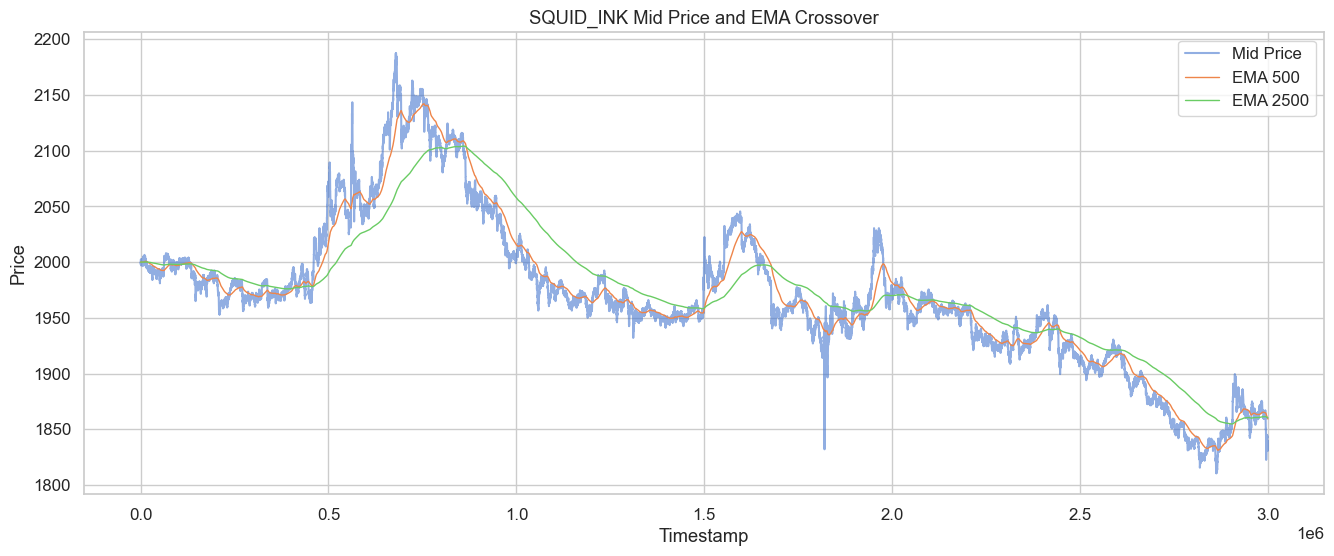

In [56]:
SHORT_WINDOW = 500
LONG_WINDOW = 2500

squid_prices['ema_short'] = squid_prices['mid_price'].ewm(span=SHORT_WINDOW, adjust=False).mean()
squid_prices['ema_long'] = squid_prices['mid_price'].ewm(span=LONG_WINDOW, adjust=False).mean()
squid_prices['ema_crossover'] = squid_prices['ema_short'] - squid_prices['ema_long']

plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.6)
plt.plot(squid_prices['timestamp'], squid_prices['ema_short'], label=f'EMA {SHORT_WINDOW}', linewidth=1)
plt.plot(squid_prices['timestamp'], squid_prices['ema_long'], label=f'EMA {LONG_WINDOW}', linewidth=1)
plt.title('SQUID_INK Mid Price and EMA Crossover')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
# Calculate the difference between short and long EMAs
squid_prices['ema_diff'] = squid_prices['ema_short'] - squid_prices['ema_long']

# Detect crossover points
squid_prices['signal'] = 0
squid_prices.loc[squid_prices['ema_diff'] > 0, 'signal'] = 1
squid_prices.loc[squid_prices['ema_diff'] < 0, 'signal'] = -1

# Detect signal change (actual cross)
squid_prices['signal_shift'] = squid_prices['signal'].shift(1)
squid_prices['crossover'] = (squid_prices['signal'] != squid_prices['signal_shift'])

# Keep only crossover rows
crossovers = squid_prices[squid_prices['crossover'] & squid_prices['signal'] != 0]
print(f"Total crossovers detected: {len(crossovers)}")

Total crossovers detected: 16


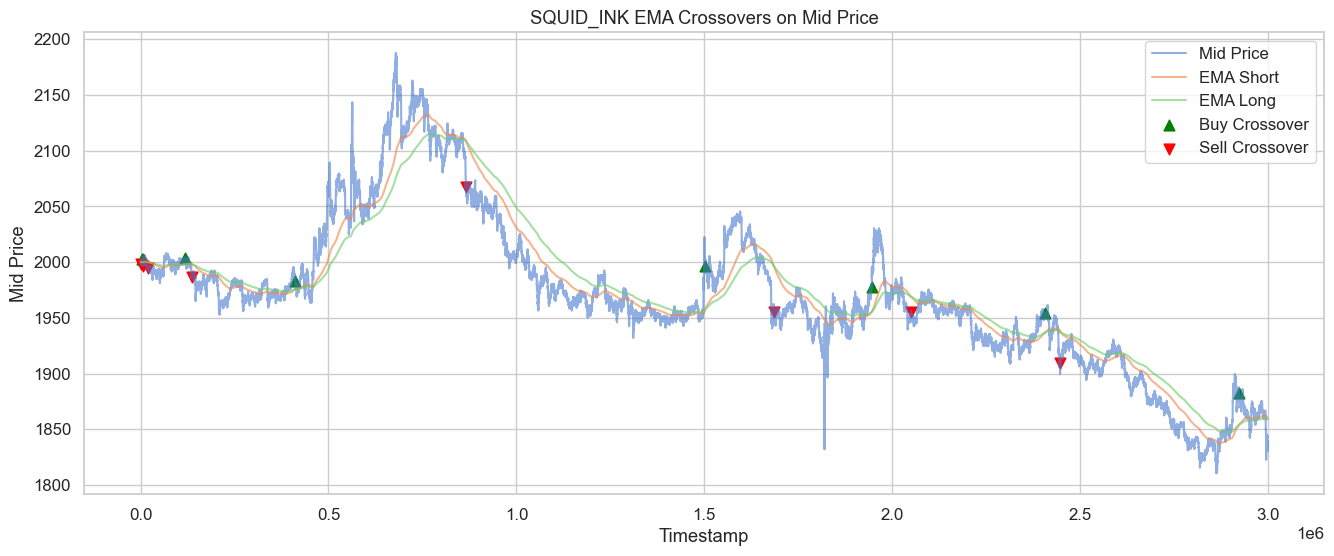

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.6)
plt.plot(squid_prices['timestamp'], squid_prices['ema_short'], label='EMA Short', alpha=0.6)
plt.plot(squid_prices['timestamp'], squid_prices['ema_long'], label='EMA Long', alpha=0.6)

# Highlight crossover points
buy_cross = crossovers[crossovers['signal'] == 1]
sell_cross = crossovers[crossovers['signal'] == -1]

plt.scatter(buy_cross['timestamp'], buy_cross['mid_price'], color='green', label='Buy Crossover', marker='^', s=60)
plt.scatter(sell_cross['timestamp'], sell_cross['mid_price'], color='red', label='Sell Crossover', marker='v', s=60)

plt.title('SQUID_INK EMA Crossovers on Mid Price')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.show()


Mean forward return after LONG entry: 38.0
Mean forward return after SHORT entry: 17.4


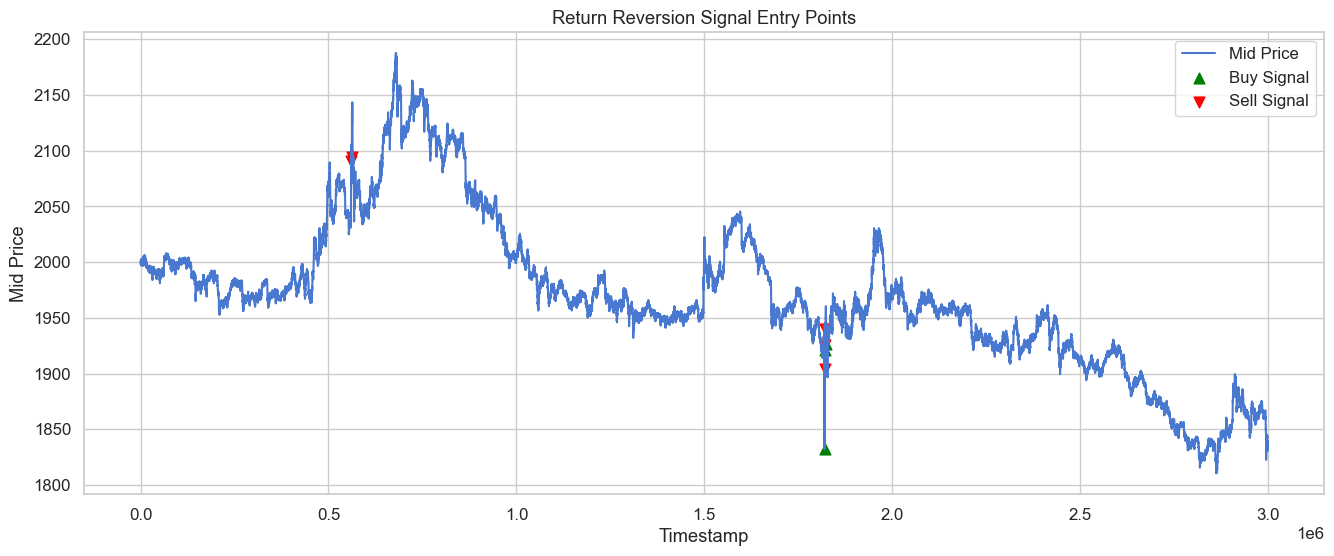

In [18]:
# Look at returns over last 10 and 20 ticks
squid_prices['ret_10'] = squid_prices['mid_price'].pct_change(periods=1)
squid_prices['ret_20'] = squid_prices['mid_price'].pct_change(periods=20)

# Entry signal: extreme short-term return
squid_prices['entry_signal'] = 0
squid_prices.loc[squid_prices['ret_10'] > 0.01, 'entry_signal'] = -1  # short
squid_prices.loc[squid_prices['ret_10'] < -0.01, 'entry_signal'] = 1  # long

# Capture signal timestamps
return_entries = squid_prices[squid_prices['entry_signal'] != 0].copy()

# Compute future return over next 30 ticks
FWD = 30
def forward_ret(row):
    idx = row.name + FWD
    if idx < len(squid_prices):
        return squid_prices.iloc[idx]['mid_price'] - row['mid_price']
    return np.nan

return_entries['forward_return'] = return_entries.apply(forward_ret, axis=1)

# Analyze returns by entry type
print("Mean forward return after LONG entry:", return_entries[return_entries['entry_signal'] == 1]['forward_return'].mean())
print("Mean forward return after SHORT entry:", return_entries[return_entries['entry_signal'] == -1]['forward_return'].mean())

plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price')

buy_pts = return_entries[return_entries['entry_signal'] == 1]
sell_pts = return_entries[return_entries['entry_signal'] == -1]

plt.scatter(buy_pts['timestamp'], buy_pts['mid_price'], color='green', marker='^', label='Buy Signal', s=60)
plt.scatter(sell_pts['timestamp'], sell_pts['mid_price'], color='red', marker='v', label='Sell Signal', s=60)

plt.title('Return Reversion Signal Entry Points')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.show()


In [19]:
# Set params
LAG = 10
THRESH = 10  # adjust based on price scale

squid_prices['momentum'] = squid_prices['mid_price'] - squid_prices['mid_price'].shift(LAG)
squid_prices['signal'] = 0
squid_prices.loc[squid_prices['momentum'] > THRESH, 'signal'] = -1  # short
squid_prices.loc[squid_prices['momentum'] < -THRESH, 'signal'] = 1  # long



In [20]:
FWD = 5  # hold duration

def forward_return(row):
    future_idx = row.name + FWD
    if future_idx < len(squid_prices):
        return squid_prices.iloc[future_idx]['mid_price'] - row['mid_price']
    return np.nan

momentum_signals = squid_prices[squid_prices['signal'] != 0].copy()
momentum_signals['forward_return'] = momentum_signals.apply(forward_return, axis=1)

print("Mean return after long (reversal buy):", momentum_signals[momentum_signals['signal'] == 1]['forward_return'].mean())
print("Mean return after short (reversal sell):", momentum_signals[momentum_signals['signal'] == -1]['forward_return'].mean())


Mean return after long (reversal buy): 0.13814616755793227
Mean return after short (reversal sell): 0.6078886310904872


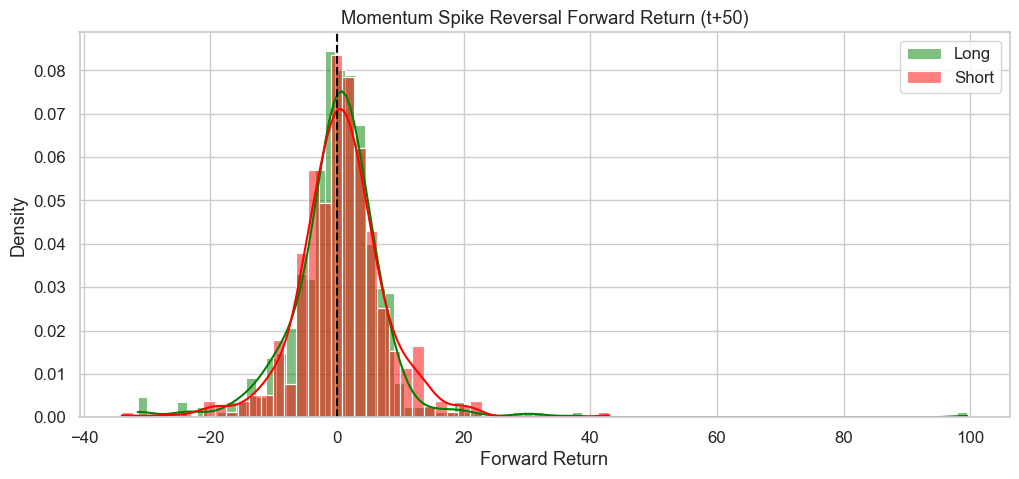

In [21]:
plt.figure(figsize=(12, 5))
sns.histplot(momentum_signals[momentum_signals['signal'] == 1]['forward_return'].dropna(), label='Long', color='green', kde=True, stat='density')
sns.histplot(momentum_signals[momentum_signals['signal'] == -1]['forward_return'].dropna(), label='Short', color='red', kde=True, stat='density')
plt.axvline(0, linestyle='--', color='black')
plt.title('Momentum Spike Reversal Forward Return (t+50)')
plt.xlabel('Forward Return')
plt.ylabel('Density')
plt.legend()
plt.show()


In [75]:
# compute and plot macd
squid_prices['ema_12'] = squid_prices['mid_price'].ewm(span=500, adjust=False).mean()
squid_prices['ema_26'] = squid_prices['mid_price'].ewm(span=2500, adjust=False).mean()
squid_prices['macd'] = squid_prices['ema_12'] - squid_prices['ema_26']
squid_prices['signal_line'] = squid_prices['macd'].ewm(span=2500, adjust=False).mean()

# Filter large trades (market trades, not ours)
large_trades = squid_trades[squid_trades['quantity'] >= 15].copy()

# Determine trade direction
def trade_direction(row):
    if row['buyer'] != 'SUBMISSION':
        return 1  # buy
    elif row['seller'] != 'SUBMISSION':
        return -1  # sell
    return 0  # unknown

large_trades['direction'] = large_trades.apply(trade_direction, axis=1)

# Join trade price with mid price at timestamp
# Assume mid_price available at or near timestamp
price_lookup = squid_prices.set_index('timestamp')['mid_price']
large_trades['mid_price'] = large_trades['timestamp'].map(price_lookup)

# Drop rows where mapping failed (edge case)
large_trades = large_trades.dropna(subset=['mid_price'])

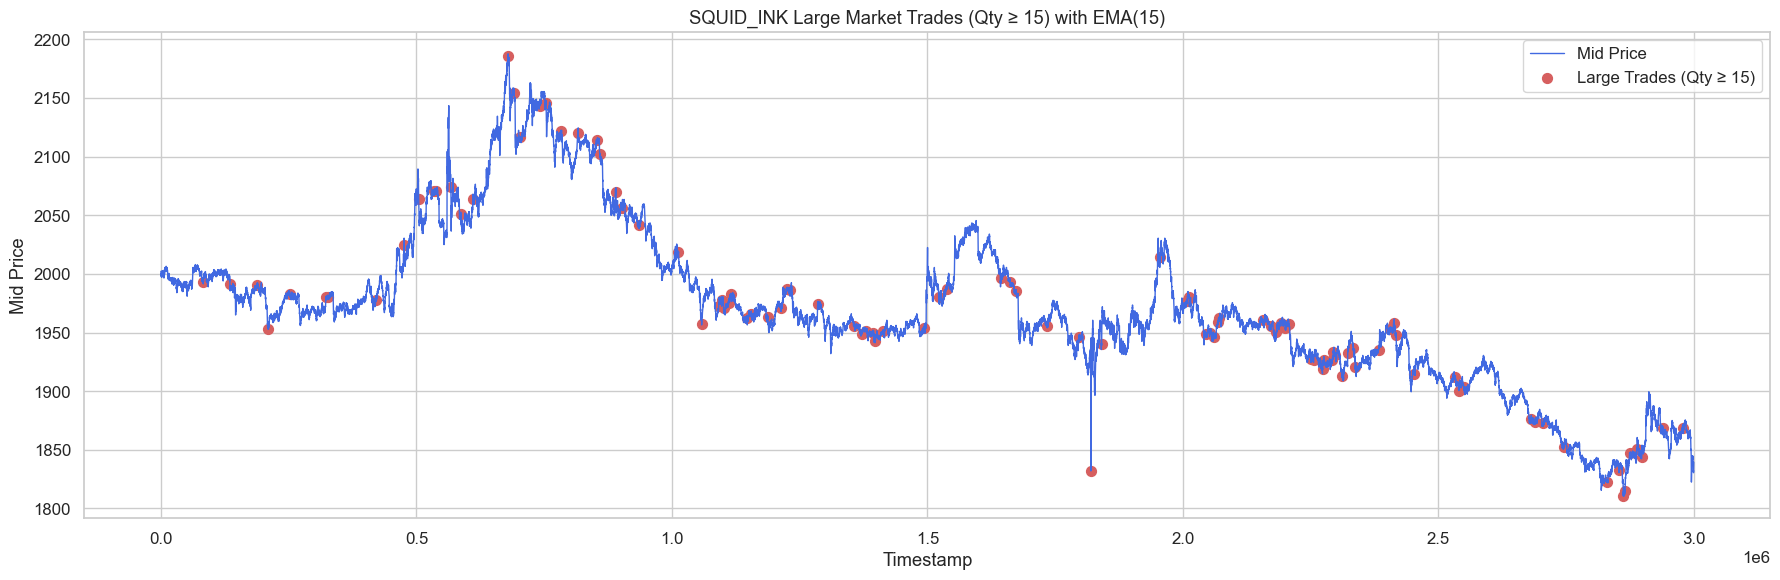

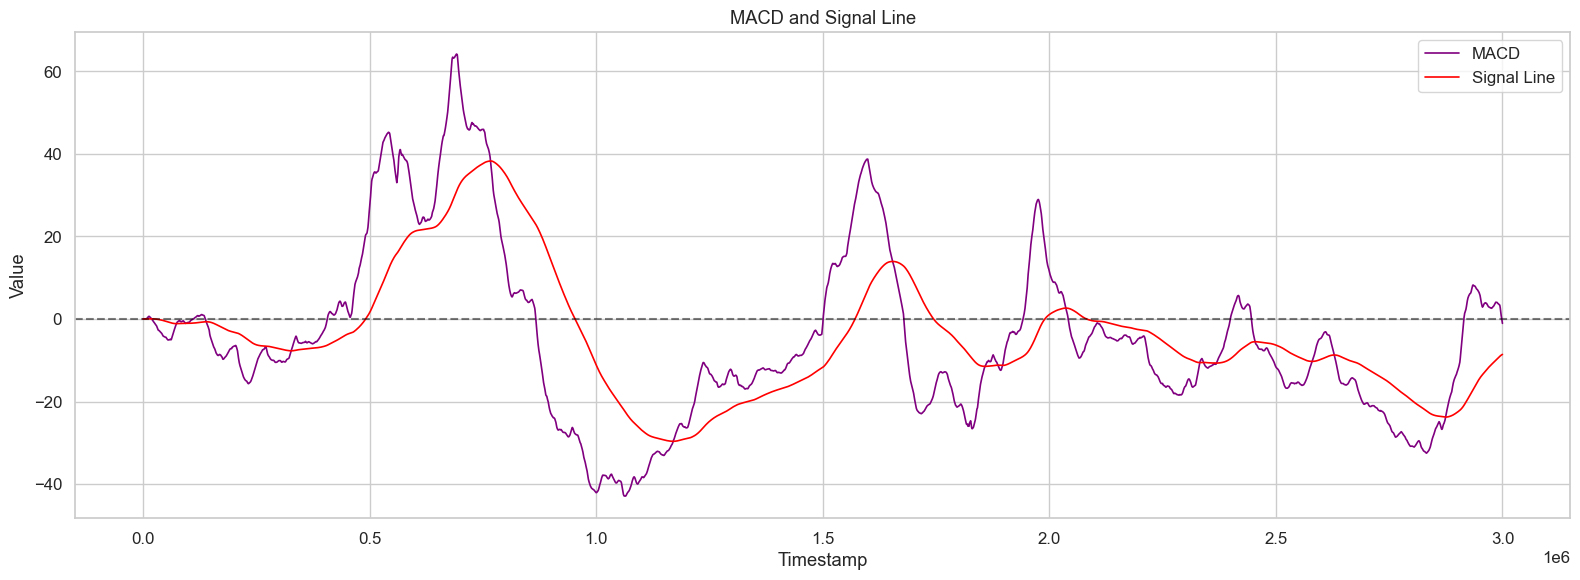

In [89]:
# Plot
plt.figure(figsize=(18, 6))

# Mid price line
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', color='royalblue', linewidth=1)

# # EMA line
# plt.plot(squid_prices['timestamp'], squid_prices['ema_15'], label='EMA(15)', color='orange', linewidth=1.2)

# Plot large trades
plt.scatter(large_trades['timestamp'], large_trades['mid_price'], color='r',
            label='Large Trades (Qty ≥ 15)', s=50, alpha=1.0, marker='o')

# Aesthetics
plt.title('SQUID_INK Large Market Trades (Qty ≥ 15) with EMA(15)')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.tight_layout()
plt.show()

# plot macd and signal line on the same graph but just underneath
plt.figure(figsize=(16, 6))
# MACD line
plt.plot(squid_prices['timestamp'], squid_prices['macd'], label='MACD', color='purple', linewidth=1.2)
# Signal line
plt.plot(squid_prices['timestamp'], squid_prices['signal_line'], label='Signal Line', color='red', linewidth=1.2)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('MACD and Signal Line')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'ema_mid'

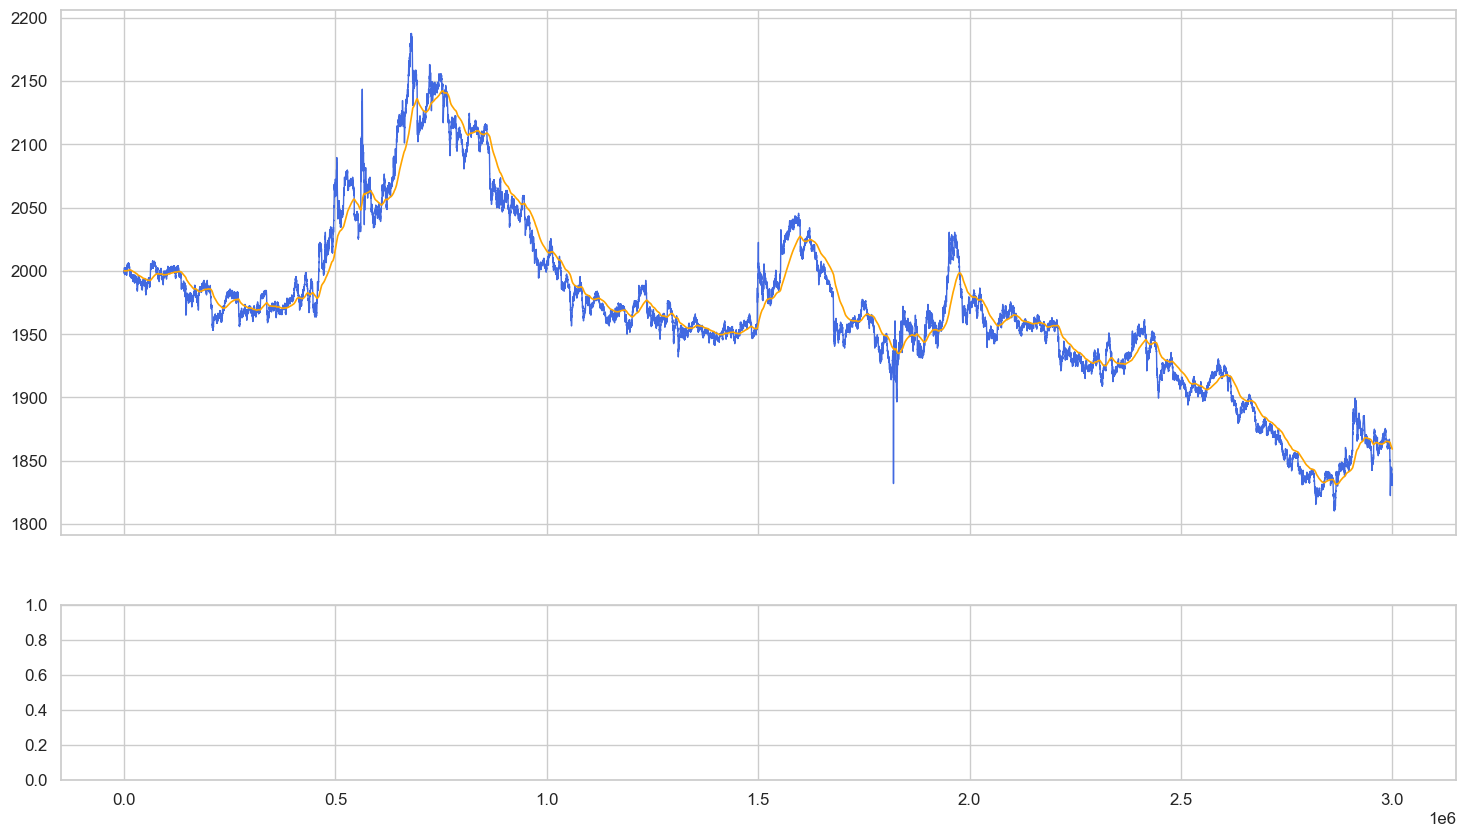

In [ ]:
# --- Compute EMA Diff ---
squid_prices['ema_short'] = squid_prices['mid_price'].ewm(span=500, adjust=False).mean()
squid_prices['ema_long'] = squid_prices['mid_price'].ewm(span=1500, adjust=False).mean()
squid_prices['ema_diff'] = squid_prices['ema_short'] - squid_prices['ema_long']

# --- Map EMA values to large_trades based on timestamp ---
ema_lookup = squid_prices.set_index('timestamp')['ema_short']
large_trades = large_trades.copy()
large_trades['ema_short'] = large_trades['timestamp'].map(ema_lookup)
large_trades = large_trades.dropna(subset=['ema_short', 'mid_price'])  # safety check

# --- Create combined figure with 2 subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# === Upper Plot: Mid Price and Large Trades ===
ax1.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', color='royalblue', linewidth=1)
ax1.plot(squid_prices['timestamp'], squid_prices['ema_short'], label='EMA(1200)', color='orange', linewidth=1.2)

# Arrows based on large trade vs. EMA
for _, row in large_trades.iterrows():
    if row['mid_price'] < row['ema_short']:
        # Buy signal: Green up arrow (price below EMA)
        ax1.annotate('', xy=(row['timestamp'], row['mid_price'] + 1), xytext=(row['timestamp'], row['mid_price']),
                     arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->', lw=3))
    else:
        # Sell signal: Red down arrow (price above EMA)
        ax1.annotate('', xy=(row['timestamp'], row['mid_price'] - 1), xytext=(row['timestamp'], row['mid_price']),
                     arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=3))

ax1.set_title('SQUID_INK Mid Price with Large Market Trades (Qty ≥ 15) vs EMA(1200)')
ax1.set_ylabel('Mid Price')
ax1.legend()

# === Lower Plot: EMA Diff ===
ax2.plot(squid_prices['timestamp'], squid_prices['ema_diff'], label='EMA(1200) - EMA(4000)', color='purple', linewidth=1.2)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Simple EMA Difference')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('EMA Diff')
ax2.legend()

plt.tight_layout()
plt.show()
